This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [59]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

## Answers:
The 2D DTFT of a is : $\hat a(\nu_x,\nu_y) = \sum_n\sum_m a(n,m)e^{-2i\pi(\nu_x n+\nu_y m)}$\
\
$\hat b(\nu_x,\nu_y) = \sum_n\sum_m b(n,m)e^{-2i\pi(\nu_x n+\nu_y m)} = \sum_n\sum_m a(n+c,m+d)e^{-2i\pi(\nu_x n+\nu_y m)} = \sum_n\sum_m a(n,m)e^{-2i\pi(\nu_x (n-c)+\nu_y(m-d))} = \sum_n\sum_m a(n,m)e^{-2i\pi(\nu_x n+\nu_y m)}e^{2i\pi(\nu_x c + \nu_y d)}$\
In the end we get : $\hat b(\nu_x,\nu_y) = \hat a(\nu_x,\nu_y)e^{2i\pi(\nu_x c + \nu_y d)}$
\
\
The 2D DFT of a is : $\hat A(k_x,k_y) = \frac 1 {N^2}\sum_{n=0}^{N-1}\sum_{m=0}^{N-1}a(n,m)e^{-2i\pi\frac{k_xn+k_ym}{N}}$\
This time the signal is not infinite so b being a translation of a is not a working solution.

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [60]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x27012bc0b50>)

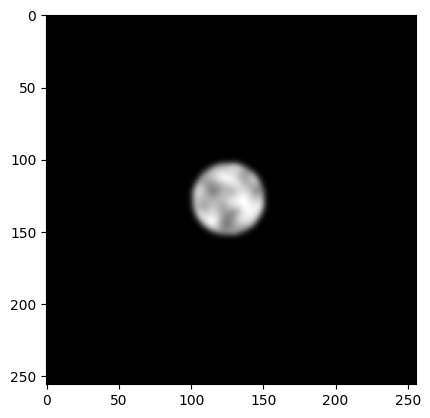

In [61]:
# Potentially add noise to the image
sigma = 2
im1 = gaussian_filter(im1,sigma)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [62]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x27012770b50>)

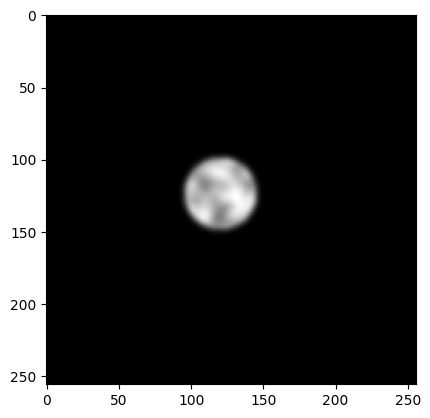

In [63]:
horiz_displacement = 5.4
vert_displacement  = 3.7
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**
If we compute the ratio between the two Fourier tranforms, according to the theoretical questions, since im2 is a translation of im1, the result should have a linear phase. We can then plot the phase of the ratio and conclude.

In [64]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [65]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [66]:
phi = angle2D(IM1/IM2)

Display phi. Is it a linear plane and why?

**Answer:**
Using the ball image without noise, phi is indeed a linear plane because im2 is a translation of im1.

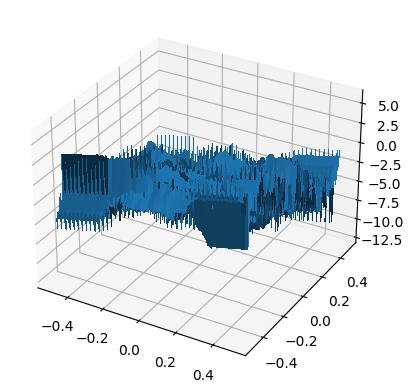

In [67]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [68]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.gradient(M,stepY,axis = 0)
    gx = np.gradient(M,stepX,axis = 1)
    
    
    return gx,gy

In [69]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [70]:
print(GX)
print(GY)

5.415838858157997
-1.5279408360362652


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.\
\
\
We first substract the central pixel of phi to phi, then we apply a median filter of radius 2 to it to reduce the impact of the potential noise in the image. We then solve a minimization problem of the form: Ax = t where A is the matrix of our data points, x is the vector of the parameters of the plane and t is the vector of the vertical components of data points (here A represents the points of the grid, x is the direction vector of the plane ie the parameters of the translation and t is the vector of the values of phi on the grid).\
 That's why after computing A we multiply t with the moore-penrose inverse of A to get the translation direction.

In [71]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [72]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [73]:
print(bEst)

[  5.8489501  -11.03075184]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

No noise:
- ball: Median method returns (10.0,1.0) and Least Square (9.999,0.9999), phi looks like a perfefct plane.
- lena: Median method returns (9.510,0.7613) and Least Square (7.907,0.01702), we can still distinguish a plane shape when looking at phi but it is extremely irregular.

Noise($\sigma = 5$):
- ball: Median method returns (10.0,1.0) and Least Square (9.998,1.000), phi looks like a plane with a small bump in the center due to the noise.
- lena: Median method returns (-0.01168,0.002589) and Least Square (0.07607,0.4067), phi has become a horizontal plane, probably because the noise has created large homogenous zones which makes the algorithm conclude that the image ahs not moved.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [74]:
from functp1 import me_ssd,displayMVF,HS

10.0
10.0


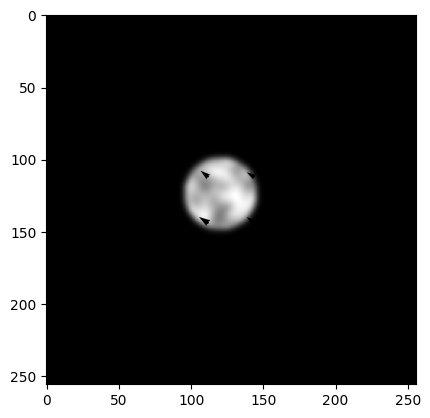

In [75]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

9.625836108723236
9.497637651210717


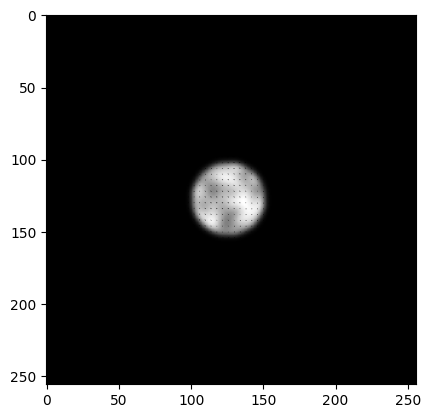

In [76]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

For some reason, the functions I implemented in the last lab are not doing what they should do, they seem to get the horizontal displacement right but the vertical one is completely wrong, each time it return a value close to 10 when it should be close to 1. Thus I will only discuss on the horizontal displacement in the next section.

Ball without noise: Block matching gets the right value, $b_x = 10.0$, optic flow is really close with $b_x=9.89$\
Ball with noise($\sigma = 2$): Block matching is as accurate with noise, $b_x = 10.0$, optic flow is a bit worse with $b_x=9.59$ because the blur made it possible for more pixels to get matched with the wrong target pixel.

This time we use non-integer displacement: b = (5.4,3.7)\
We get:
- without noise: Block matching still gets $b_x = 10.0$ and optic flow gets $b_x = 9.89$
- with noise($\sigma = 2$): Block matching still gets $b_x = 10.0$ and optic flow gets $b_x = 9.62$

There is definitely a problem with my functions, even though they produced satisfactory results in the last lab. What we would expect though is that by using non integer values for the displacement, some precision would be lost due to interpolation and the results of both of the methods would be worse. Optical flow would be especially worse since it always performed worse than block matching and interpolation combined with noise would allow for a lot of mismatches.